In [1]:
import torch

In [2]:
import os
from PIL import Image
from torchvision import transforms
from torchvision.datasets import DatasetFolder
import cv2
import numpy as np


def load_image(img_path:str):    
        np_img = cv2.imread(img_path) #CV2 to open and convert BMP mages into NUMPY    
        #np_img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        return Image.fromarray(np_img)  #we need Image for the transforms to work correctly

dset = DatasetFolder(root='RowanDLclassNEA/NEUdata', loader = load_image, extensions = ('.bmp',))


# We need to write a transform to make it compatible with resnet18 (size 224x224x3, and type tensor)

In [3]:
from torchvision import transforms

transform = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize(
      mean=[0.485, 0.456, 0.406],
      std=[0.229, 0.224, 0.225])])

dset = DatasetFolder(root='RowanDLclassNEA/NEUdata', loader = load_image, extensions = ('.bmp',), transform = transform)

### Note that load_image  needed to return a PIL.Image for the transforms to be correctly applied


In [5]:
from torch.utils.data import random_split

train_set, val_set = random_split(
                      dset, 
                      [1200, 600])

trainloader = torch.utils.data.DataLoader(
                    train_set, 
                    batch_size=16, 
                    shuffle=True)

valloader = torch.utils.data.DataLoader(
                    val_set, 
                    batch_size=16, 
                    shuffle=True)



 ### We are going to illustrate transfer learning now
Transfer starts with a pretrained model from the torchvision library. The pretrained model will be resnet18. This model is trained on ImageNet 1K (this is the default for resnet18: DEFAULT = IMAGENET1K_V1)
The fact that ImageNet consists of RGB images of size 224 x 224 demanded our data resizing in the transform

In [6]:
import torchvision.models as models
import torch.nn as nn
from torchinfo import summary

orig_model = models.resnet18(weights = models.ResNet18_Weights.IMAGENET1K_V1)
summary(orig_model, input_size=(16, 3, 224, 224), row_settings=("depth", "ascii_only"))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [16, 1000]                --
+ Conv2d: 1-1                            [16, 64, 112, 112]        9,408
+ BatchNorm2d: 1-2                       [16, 64, 112, 112]        128
+ ReLU: 1-3                              [16, 64, 112, 112]        --
+ MaxPool2d: 1-4                         [16, 64, 56, 56]          --
+ Sequential: 1-5                        [16, 64, 56, 56]          --
|    + BasicBlock: 2-1                   [16, 64, 56, 56]          --
|    |    + Conv2d: 3-1                  [16, 64, 56, 56]          36,864
|    |    + BatchNorm2d: 3-2             [16, 64, 56, 56]          128
|    |    + ReLU: 3-3                    [16, 64, 56, 56]          --
|    |    + Conv2d: 3-4                  [16, 64, 56, 56]          36,864
|    |    + BatchNorm2d: 3-5             [16, 64, 56, 56]          128
|    |    + ReLU: 3-6                    [16, 64, 56, 56]          --
|

### notice that the last layer of the resnet18 is a linear layer with output size 1000

We will first deepcopy  orig_model (where we instantiated resnet18 with pretrained weights): this will create an INDEPENDENT graph

Then just replace model.fc with the linear layer


In [7]:
import copy
alt_model = copy.deepcopy(orig_model)
alt_model.fc = nn.Linear(512,6)

In [8]:
from torch import optim
from torch import nn
import torch.optim.lr_scheduler as lr_scheduler

criterion = nn.CrossEntropyLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"
model = alt_model.to(device)

optimizer = optim.SGD(model.parameters(), 
                      lr=0.001, 
                      momentum=0.9)
 
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.25, total_iters=10)



N_EPOCHS = 20
tr_loss_hist = []
val_loss_hist = []
for epoch in range(N_EPOCHS):

    # Training 
    train_loss = 0.0
    model.train() # <1>
    for inputs, labels in trainloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

    # Validation
    val_loss = 0.0
    model.eval() # <2>
    for inputs, labels in valloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        val_loss += loss.item()

    print("Epoch: {} Train Loss: {} Val Loss: {}".format(
                  epoch, 
                  train_loss/len(trainloader), 
                  val_loss/len(valloader)))
    tr_loss_hist.append(train_loss/len(trainloader))
    val_loss_hist.append(val_loss/len(valloader))

Epoch: 0 Train Loss: 0.8729699850082397 Val Loss: 0.2888766217388605
Epoch: 1 Train Loss: 0.2754430607954661 Val Loss: 0.11370972691005782
Epoch: 2 Train Loss: 0.1516545029481252 Val Loss: 0.06733597501328117
Epoch: 3 Train Loss: 0.1082264994084835 Val Loss: 0.05006346903055122
Epoch: 4 Train Loss: 0.07170478458205859 Val Loss: 0.034427164490089604
Epoch: 5 Train Loss: 0.07827730353921653 Val Loss: 0.02892071702272484
Epoch: 6 Train Loss: 0.05844032798583309 Val Loss: 0.024034673715696522
Epoch: 7 Train Loss: 0.05775151249021292 Val Loss: 0.024222571016779465
Epoch: 8 Train Loss: 0.03566292385260264 Val Loss: 0.021400897279626838
Epoch: 9 Train Loss: 0.03633868345990777 Val Loss: 0.01743562406504919
Epoch: 10 Train Loss: 0.02769749889150262 Val Loss: 0.015407603926417468
Epoch: 11 Train Loss: 0.028414517116422455 Val Loss: 0.025074686227047716
Epoch: 12 Train Loss: 0.02720090054286023 Val Loss: 0.012872758710536322
Epoch: 13 Train Loss: 0.026729912363613644 Val Loss: 0.0163251933899070

Text(0.5, 1.0, 'Loss Curves')

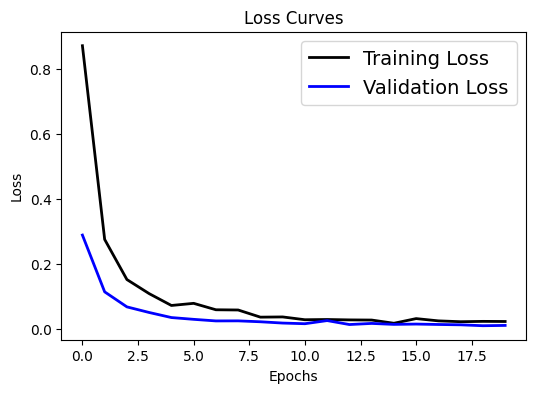

In [9]:
import matplotlib.pyplot as plt

# Plotting the loss curve
plt.figure(figsize=[6,4])
plt.plot(tr_loss_hist, 'black', linewidth=2.0)
plt.plot(val_loss_hist, 'blue', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

#### This is a different way of changing the resnet18

Let's get rid of the last layer of the resnet18 (output size 1000), because we have only 6 classes!

Plus, add the FlattenLayer to see what is the linearized size of the last AvgPool

We will use this shortened model (vec_model) to build upon it later, but first we will **freeze its parameters** (disable further training)


In [10]:
layers = list(orig_model.children())[:-1]  #get all the layers except the last one
layers.append(nn.Flatten())   
vec_model = nn.Sequential(*layers)
for param in vec_model.parameters():
    param.requires_grad = False

## Here we will add linear layer to the frozen vec_model

In [11]:
layers = list(vec_model.children())  #get all the layers except the last one
layers.append(nn.Linear(512,6))
vec_model = nn.Sequential(*layers)
summary(vec_model, input_size=(16, 3, 224, 224), row_settings=("depth", "ascii_only"))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [16, 6]                   --
+ Conv2d: 1-1                            [16, 64, 112, 112]        (9,408)
+ BatchNorm2d: 1-2                       [16, 64, 112, 112]        (128)
+ ReLU: 1-3                              [16, 64, 112, 112]        --
+ MaxPool2d: 1-4                         [16, 64, 56, 56]          --
+ Sequential: 1-5                        [16, 64, 56, 56]          --
|    + BasicBlock: 2-1                   [16, 64, 56, 56]          --
|    |    + Conv2d: 3-1                  [16, 64, 56, 56]          (36,864)
|    |    + BatchNorm2d: 3-2             [16, 64, 56, 56]          (128)
|    |    + ReLU: 3-3                    [16, 64, 56, 56]          --
|    |    + Conv2d: 3-4                  [16, 64, 56, 56]          (36,864)
|    |    + BatchNorm2d: 3-5             [16, 64, 56, 56]          (128)
|    |    + ReLU: 3-6                    [16, 64, 56, 56]  

#### Train vec_model

In [12]:
from torch import optim
from torch import nn
import torch.optim.lr_scheduler as lr_scheduler

criterion = nn.CrossEntropyLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"
model = vec_model.to(device)

optimizer = optim.SGD(model.parameters(), 
                      lr=0.001, 
                      momentum=0.9)
 
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.25, total_iters=10)


#from torch.utils.tensorboard import SummaryWriter

N_EPOCHS = 20
tr_loss_hist = []
val_loss_hist = []
for epoch in range(N_EPOCHS):

    # Training 
    train_loss = 0.0
    model.train() # <1>
    for inputs, labels in trainloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

    # Validation
    val_loss = 0.0
    model.eval() # <2>
    for inputs, labels in valloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        val_loss += loss.item()

    print("Epoch: {} Train Loss: {} Val Loss: {}".format(
                  epoch, 
                  train_loss/len(trainloader), 
                  val_loss/len(valloader)))
    tr_loss_hist.append(train_loss/len(trainloader))
    val_loss_hist.append(val_loss/len(valloader))

Epoch: 0 Train Loss: 1.30601438442866 Val Loss: 0.8514635751121923
Epoch: 1 Train Loss: 0.7333353809515635 Val Loss: 0.5149234478410921
Epoch: 2 Train Loss: 0.527903261979421 Val Loss: 0.3688531576802856
Epoch: 3 Train Loss: 0.4332498518625895 Val Loss: 0.2968461917419183
Epoch: 4 Train Loss: 0.3628040713071823 Val Loss: 0.26058138279538406
Epoch: 5 Train Loss: 0.3133231967687607 Val Loss: 0.2229659816152171
Epoch: 6 Train Loss: 0.2823476368188858 Val Loss: 0.1984887477990828
Epoch: 7 Train Loss: 0.2710593956708908 Val Loss: 0.18403131152062038
Epoch: 8 Train Loss: 0.2448698051770528 Val Loss: 0.1656250584086305
Epoch: 9 Train Loss: 0.2192882157365481 Val Loss: 0.1545366968371366
Epoch: 10 Train Loss: 0.2150230151414871 Val Loss: 0.15011660450775371
Epoch: 11 Train Loss: 0.21059926504890125 Val Loss: 0.13777633923056878
Epoch: 12 Train Loss: 0.1842168550690015 Val Loss: 0.13491116375907472
Epoch: 13 Train Loss: 0.17834369818369547 Val Loss: 0.12104236814928682
Epoch: 14 Train Loss: 0.1

Text(0.5, 1.0, 'Loss Curves')

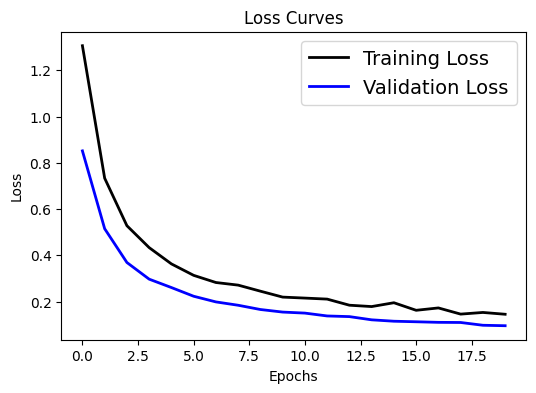

In [13]:
import matplotlib.pyplot as plt

# Plotting the loss curve
plt.figure(figsize=[6,4])
plt.plot(tr_loss_hist, 'black', linewidth=2.0)
plt.plot(val_loss_hist, 'blue', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)